In [ ]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [ ]:
df = pd.read_csv('df_master_TM_proj (1).csv')

In [ ]:


# NLTK 리소스 (Colab 필수)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')

# 1. Lemmatizer 초기화
lemmatizer = WordNetLemmatizer()

# 2. Treebank POS -> WordNet POS 변환
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# 3. Lemmatization 함수
def lemmatize_text(text):
    if pd.isna(text) or text is None:
        return ""
    tokens = str(text).split()
    tagged_tokens = nltk.pos_tag(tokens)

    lemmatized_tokens = []
    for word, tag in tagged_tokens:
        pos = get_wordnet_pos(tag)
        lemmatized_tokens.append(lemmatizer.lemmatize(word, pos=pos))

    return " ".join(lemmatized_tokens)

# 4. CSV 로드
df = pd.read_csv('df_master_TM_proj (1).csv')

# 5. cleaned_text에 lemmatization 적용
df['cleaned_text_lemma'] = df['cleaned_text'].apply(lemmatize_text)

# 6. 확인
df[['cleaned_text', 'cleaned_text_lemma']].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,cleaned_text,cleaned_text_lemma
0,yield us 10-year treasury note edged 4.14 thur...,yield u 10-year treasury note edge 4.14 thursd...
1,traders remained cautious awaiting fresh catal...,trader remain cautious await fresh catalyst ti...
2,markets continue price two additional 25-basis...,market continue price two additional 25-basis-...
3,wednesday senate rejected funding proposals re...,wednesday senate reject funding proposal repub...
4,meanwhile treasury department ’ auction 10-yea...,meanwhile treasury department ’ auction 10-yea...


In [ ]:
df.to_csv('df_master_TM_proj_lemma.csv', index=False)

In [ ]:
from google.colab import files
files.download('df_master_TM_proj_lemma.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import math
from collections import Counter

TEXT_COL = 'cleaned_text_lemma'

min_freq_by_n = {
    2: 30,
    3: 20,
    4: 10,
    5: 5
}

topk_by_n = {
    2: None,
    3: None,
    4: None,
    5: None
}

out_files = {
    2: 'bigram_col.csv',
    3: 'trigram_col.csv',
    4: 'fourgram_col.csv',
    5: 'fivegram_col.csv'
}

def build_counts(texts):
    unigram_counts = Counter()
    ngram_counts = {n: Counter() for n in range(2, 6)}

    for sent in texts:
        tokens = str(sent).split()
        if len(tokens) == 0:
            continue

        unigram_counts.update(tokens)

        L = len(tokens)
        for n in range(2, 6):
            if L < n:
                continue
            for i in range(L - n + 1):
                ng = tuple(tokens[i:i+n])
                ngram_counts[n][ng] += 1

    total_unigrams = sum(unigram_counts.values())
    return unigram_counts, ngram_counts, total_unigrams

def compute_pmi_for_n(ngram_counts, unigram_counts, total_unigrams, n, min_freq=10, topk=None):
    total_ngrams_n = sum(ngram_counts[n].values())
    rows = []

    if total_ngrams_n == 0 or total_unigrams == 0:
        return pd.DataFrame(columns=['ngram', 'freq', 'pmi'])

    tu = float(total_unigrams)
    tng = float(total_ngrams_n)

    for ngram, c in ngram_counts[n].items():
        if c < min_freq:
            continue

        denom = 1.0
        ok = True
        for w in ngram:
            cw = unigram_counts.get(w, 0)
            if cw == 0:
                ok = False
                break
            denom = denom * float(cw)

        if not ok:
            continue

        p_ng = float(c) / tng
        p_prod = denom / (tu ** n)

        if p_ng <= 0.0 or p_prod <= 0.0:
            continue

        pmi = math.log2(p_ng / p_prod)

        rows.append({
            'ngram': " ".join(ngram),
            'freq': int(c),
            'pmi': float(pmi)
        })

    df_pmi = pd.DataFrame(rows)
    if df_pmi.empty:
        return df_pmi

    df_pmi = df_pmi.sort_values(['pmi', 'freq'], ascending=[False, False]).reset_index(drop=True)

    if topk is not None:
        df_pmi = df_pmi.head(int(topk))

    return df_pmi

texts = df[TEXT_COL].dropna().astype(str).tolist()

unigram_counts, ngram_counts, total_unigrams = build_counts(texts)

for n in [2, 3, 4, 5]:
    df_out = compute_pmi_for_n(
        ngram_counts=ngram_counts,
        unigram_counts=unigram_counts,
        total_unigrams=total_unigrams,
        n=n,
        min_freq=min_freq_by_n[n],
        topk=topk_by_n[n]
    )
    df_out.to_csv(out_files[n], index=False, encoding='utf-8-sig')
    print('saved :', out_files[n], 'rows :', len(df_out))

saved : bigram_col.csv rows : 43117
saved : trigram_col.csv rows : 73901
saved : fourgram_col.csv rows : 109547
saved : fivegram_col.csv rows : 137612



AUDIT 2-gram
rows : 43117
missing ngram : 0 missing freq : 0 missing pmi : 0
duplicate ngram : 0
freq min/median/max : 30.0 57.0 22212.0
pmi  min/median/max : -3.923221947891484 3.9474847448172734 18.168718431237405

Top PMI
                         ngram  freq        pmi
0                zeynep senyuz    31  18.168718
1              schulhofer wohl    33  18.035452
2                pernod ricard    35  17.993632
3  emergencies appropriateness    33  17.913461
4             société générale    37  17.913461
5                larsen toubro    37  17.913461
6            rebecca zarutskie    32  17.913461
7               raj rajaratnam    30  17.897948
8                 nellie liang    40  17.729739
9                mercedes benz    35  17.724721

Top FREQ
                     ngram   freq       pmi
8400       federal reserve  22212  6.780526
8271         interest rate  15575  6.822670
8843           open market  14880  6.647067
8580          reserve bank  13371  6.718480
5440        four

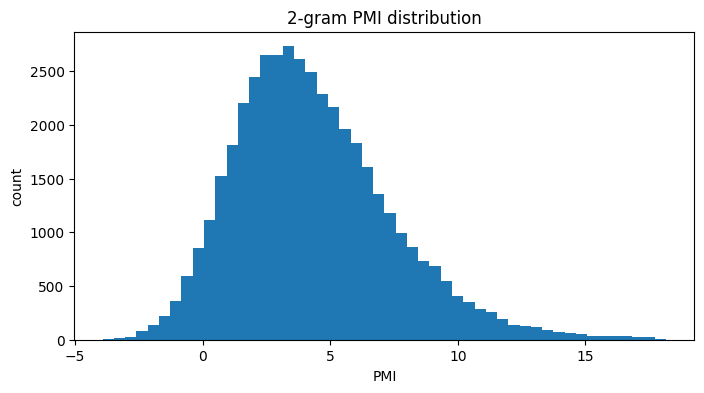

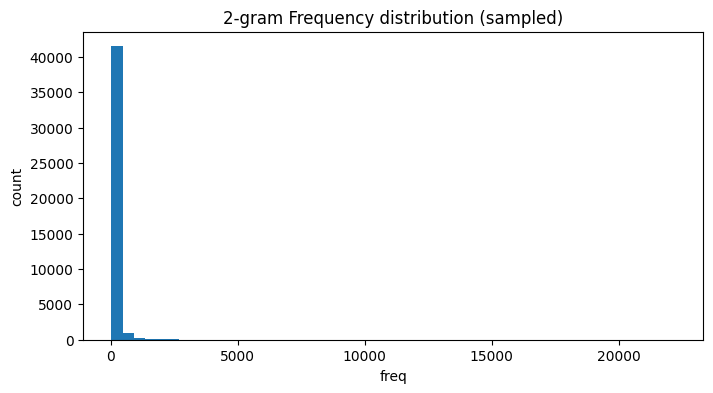

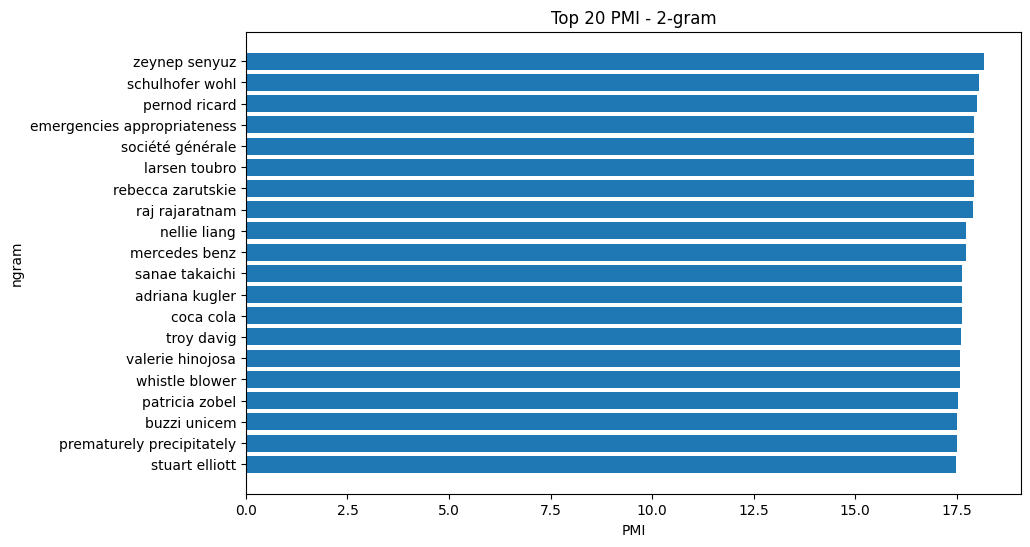


AUDIT 3-gram
rows : 73901
missing ngram : 0 missing freq : 0 missing pmi : 0
duplicate ngram : 0
freq min/median/max : 20.0 31.0 12570.0
pmi  min/median/max : 2.545729059353597 12.823819253715843 37.33119793199377

Top PMI
                               ngram  freq        pmi
0               marnie gillis deboer    22  37.331198
1                          kei mu yi    20  36.758208
2                  burcu duygan bump    28  35.919144
3             samuel schulhofer wohl    33  35.407711
4               bristol myers squibb    22  35.355657
5             precision alterna tive    24  35.272781
6  federalreserve gov monetarypolicy    26  34.767253
7             www federalreserve gov    27  34.714786
8                   monte dei paschi    59  34.294337
9                    osama bin laden    33  34.194779

Top FREQ
                             ngram   freq        pmi
29438            federal fund rate  12570  13.882325
28358         federal reserve bank  12230  14.039774
38238        

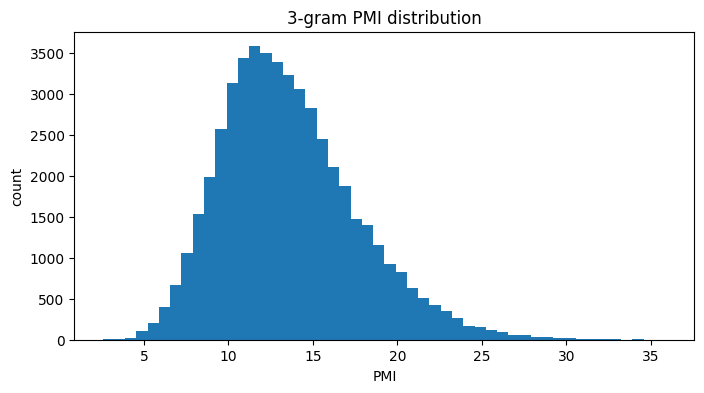

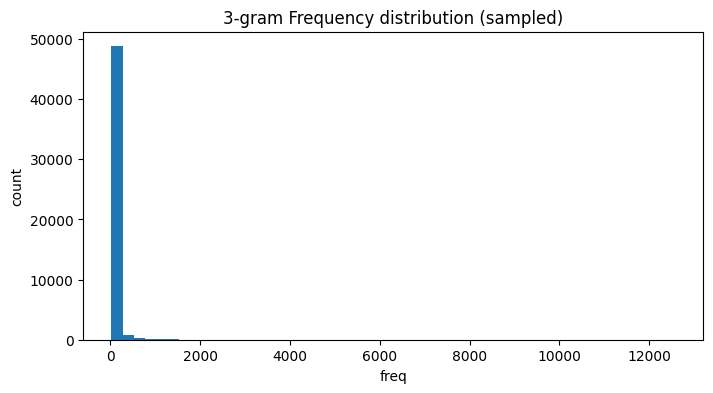

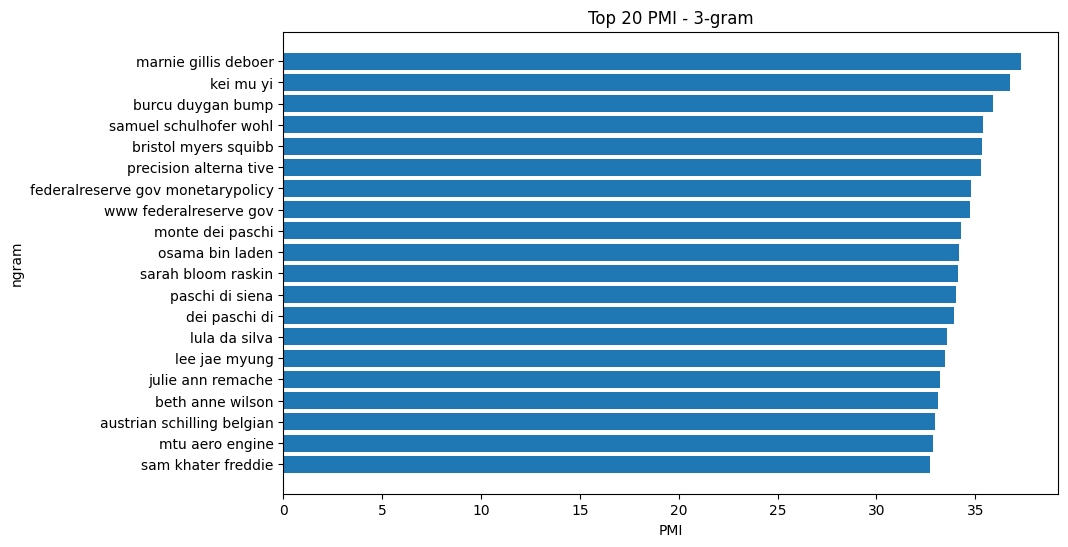


AUDIT 4-gram
rows : 109547
missing ngram : 0 missing freq : 0 missing pmi : 0
duplicate ngram : 0
freq min/median/max : 10.0 23.0 6533.0
pmi  min/median/max : 9.523752823662017 22.344614632805012 53.09169498452833

Top PMI
                                   ngram  freq        pmi
0  www federalreserve gov monetarypolicy    26  53.091695
1                    luiz inacio lula da    10  52.166325
2                   inacio lula da silva    10  51.956871
3                       aung san suu kyi    13  51.583468
4                       daw aung san suu    12  51.583468
5                 burcu duygan bump jane    11  51.417615
6                    dei paschi di siena    54  51.213950
7                     sec gen kofi annan    10  51.195125
8                    monte dei paschi di    54  51.069560
9         imputed owner occupy residence    11  50.701911

Top FREQ
                                       ngram  freq        pmi
76394          federal open market committee  6533  20.079496
3911

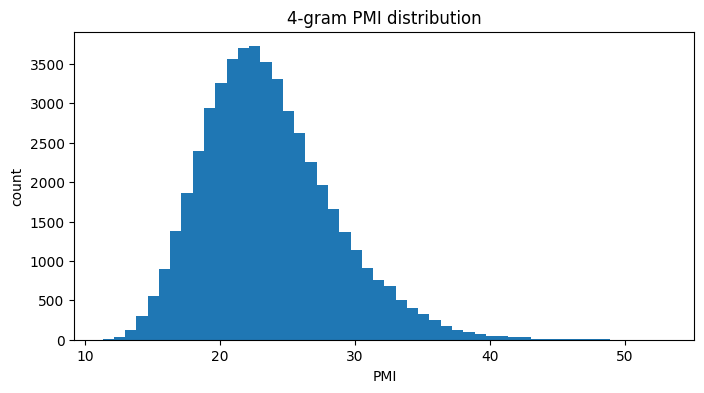

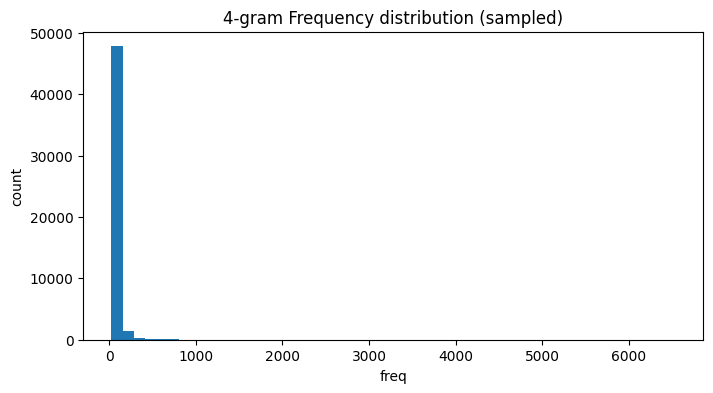

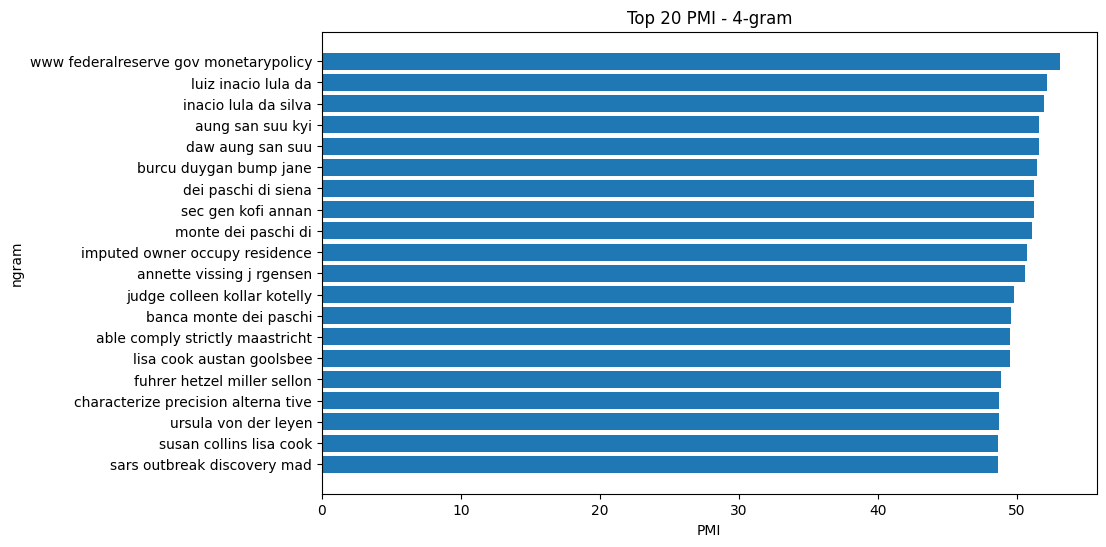


AUDIT 5-gram
rows : 137612
missing ngram : 0 missing freq : 0 missing pmi : 0
duplicate ngram : 0
freq min/median/max : 5.0 19.0 6459.0
pmi  min/median/max : 15.602355631924684 32.25246616962308 71.30544746725664

Top PMI
                                         ngram  freq        pmi
0   http www federalreserve gov monetarypolicy     6  71.305447
1  https www federalreserve gov monetarypolicy     5  71.264805
2                         daw aung san suu kyi    12  71.019613
3                    luiz inacio lula da silva    10  70.093456
4                    luiz inácio lula da silva     7  70.093456
5                     luiz incio lula da silva     5  70.093456
6                  jaguar land rover jlr volvo     6  69.740353
7             lvmh moet hennessy louis vuitton     5  69.432226
8                 marnie gillis deboer min wei     5  69.397333
9                    monte dei paschi di siena    54  68.373254

Top FREQ
                                             ngram  freq       

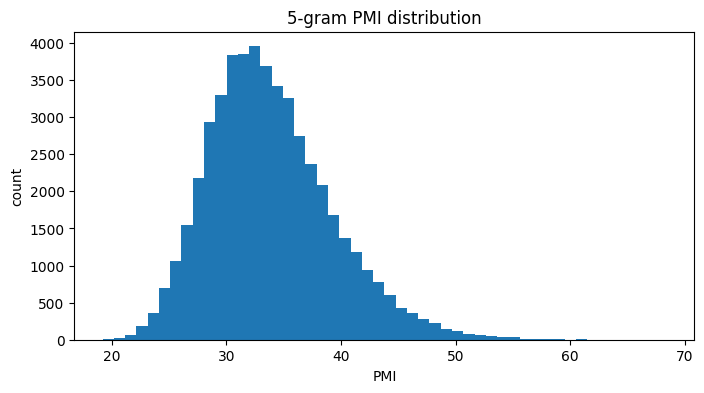

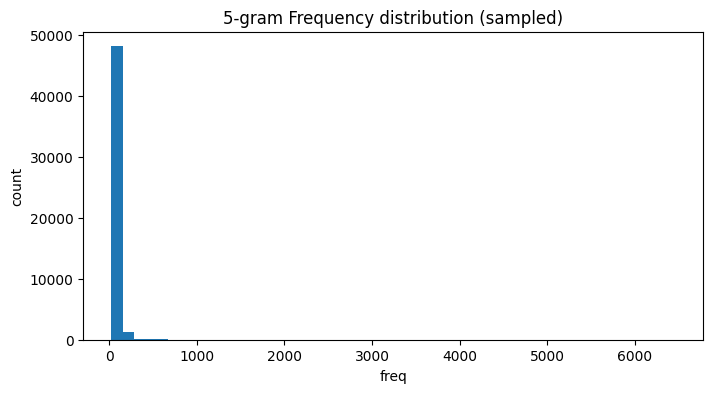

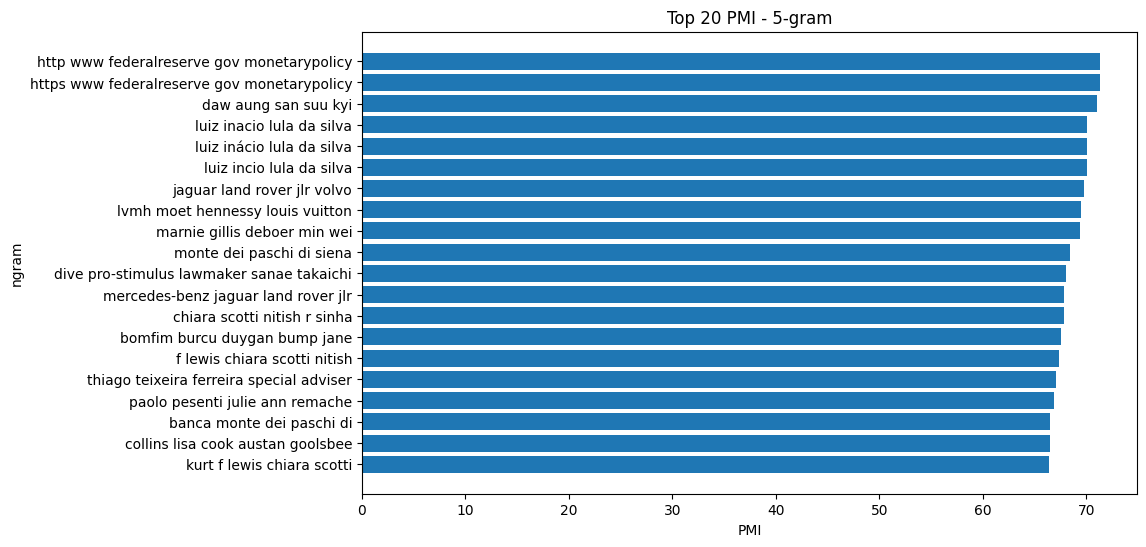


===== SUMMARY =====
   n    rows  freq_median  pmi_median    pmi_max
0  2   43117         57.0    3.947485  18.168718
1  3   73901         31.0   12.823819  37.331198
2  4  109547         23.0   22.344615  53.091695
3  5  137612         19.0   32.252466  71.305447


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 0) 너가 만든 파일명 연결
# =========================
files = {
    2: 'bigram_col.csv',
    3: 'trigram_col.csv',
    4: 'fourgram_col.csv',
    5: 'fivegram_col.csv'
}

def load_and_standardize(path):
    dfc = pd.read_csv(path)
    dfc.columns = [c.lower().strip() for c in dfc.columns]

    # 컬럼명 유연하게 맞추기
    if 'count' in dfc.columns and 'freq' not in dfc.columns:
        dfc = dfc.rename(columns={'count': 'freq'})
    if 'ngram' not in dfc.columns:
        # 혹시 ngram 컬럼명이 다르면 여기서 추가 처리
        pass

    # 필요한 컬럼만 정리
    keep = [c for c in ['ngram', 'freq', 'pmi'] if c in dfc.columns]
    dfc = dfc[keep].copy()

    # 타입 정리
    if 'freq' in dfc.columns:
        dfc['freq'] = pd.to_numeric(dfc['freq'], errors='coerce')
    if 'pmi' in dfc.columns:
        dfc['pmi'] = pd.to_numeric(dfc['pmi'], errors='coerce')

    return dfc

# =========================
# 1) 검수 리포트
# =========================
def audit_report(dfc, n, top_show=10):
    print('\n' + '='*30)
    print('AUDIT', str(n) + '-gram')
    print('='*30)

    print('rows :', len(dfc))
    if len(dfc) == 0:
        return

    # 결측
    miss_ng = int(dfc['ngram'].isna().sum()) if 'ngram' in dfc.columns else 0
    miss_fr = int(dfc['freq'].isna().sum()) if 'freq' in dfc.columns else 0
    miss_pm = int(dfc['pmi'].isna().sum()) if 'pmi' in dfc.columns else 0
    print('missing ngram :', miss_ng, 'missing freq :', miss_fr, 'missing pmi :', miss_pm)

    # 중복
    dup = int(dfc['ngram'].duplicated().sum()) if 'ngram' in dfc.columns else 0
    print('duplicate ngram :', dup)

    # 음수/이상치 체크
    if 'freq' in dfc.columns:
        print('freq min/median/max :',
              float(dfc['freq'].min()), float(dfc['freq'].median()), float(dfc['freq'].max()))
    if 'pmi' in dfc.columns:
        print('pmi  min/median/max :',
              float(dfc['pmi'].min()), float(dfc['pmi'].median()), float(dfc['pmi'].max()))

    # 상위 PMI / 상위 빈도
    print('\nTop PMI')
    print(dfc.sort_values(['pmi', 'freq'], ascending=[False, False]).head(top_show))
    print('\nTop FREQ')
    print(dfc.sort_values(['freq', 'pmi'], ascending=[False, False]).head(top_show))

# =========================
# 2) 시각화
# =========================
def visualize(dfc, n, hist_limit=50000, topk_bar=20):
    if len(dfc) == 0:
        return

    # 너무 큰 경우 시각화는 샘플링 (freq 기준 상위 hist_limit)
    dfv = dfc.copy()
    if len(dfv) > hist_limit:
        dfv = dfv.sort_values(['freq', 'pmi'], ascending=[False, False]).head(hist_limit)

    # PMI 분포
    plt.figure(figsize=(8, 4))
    plt.hist(dfv['pmi'].dropna(), bins=50)
    plt.title(str(n) + '-gram PMI distribution')
    plt.xlabel('PMI')
    plt.ylabel('count')
    plt.show()

    # freq 분포
    plt.figure(figsize=(8, 4))
    plt.hist(dfv['freq'].dropna(), bins=50)
    plt.title(str(n) + '-gram Frequency distribution (sampled)')
    plt.xlabel('freq')
    plt.ylabel('count')
    plt.show()

    # Top PMI bar chart
    top = dfc.sort_values(['pmi', 'freq'], ascending=[False, False]).head(topk_bar).copy()
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top)), top['pmi'])
    plt.yticks(range(len(top)), top['ngram'])
    plt.gca().invert_yaxis()
    plt.title('Top ' + str(topk_bar) + ' PMI - ' + str(n) + '-gram')
    plt.xlabel('PMI')
    plt.ylabel('ngram')
    plt.show()

# =========================
# 3) 전체 실행 + 요약 비교
# =========================
summary_rows = []

for n in [2, 3, 4, 5]:
    path = files[n]
    if not os.path.exists(path):
        print('missing :', path)
        continue

    dfc = load_and_standardize(path)

    audit_report(dfc, n)
    visualize(dfc, n)

    # 요약(비교용)
    if len(dfc) > 0:
        summary_rows.append({
            'n': n,
            'rows': len(dfc),
            'freq_median': float(dfc['freq'].median()),
            'pmi_median': float(dfc['pmi'].median()),
            'pmi_max': float(dfc['pmi'].max())
        })

summary = pd.DataFrame(summary_rows).sort_values('n')
print('\n===== SUMMARY =====')
print(summary)

In [ ]:
import pandas as pd

bigram_coll = pd.read_csv('bigram_col.csv')

In [ ]:
bigram_coll.sort_values('freq', ascending=False).head(20)

,ngram,freq,pmi
8400,federal reserve,22212,6.780526
8271,interest rate,15575,6.822670
8843,open market,14880,6.647067
8580,reserve bank,13371,6.718480
5440,fourth quarter,13171,7.881437
7837,federal fund,13078,6.958209
9536,economic activity,12837,6.448871
9521,fund rate,12757,6.453652
4931,intermeeting period,12583,8.132952
10045,monetary policy,10477,6.307168


In [ ]:
bigram_coll.sort_values('pmi', ascending=False).head(20)

,ngram,freq,pmi
0,zeynep senyuz,31,18.168718
1,schulhofer wohl,33,18.035452
2,pernod ricard,35,17.993632
3,emergencies appropriateness,33,17.913461
4,société générale,37,17.913461
5,larsen toubro,37,17.913461
6,rebecca zarutskie,32,17.913461
7,raj rajaratnam,30,17.897948
8,nellie liang,40,17.729739
9,mercedes benz,35,17.724721


In [ ]:
bigram_coll.sort_values(['freq', 'pmi'], ascending=[False, False]).head(20)

,ngram,freq,pmi
8400,federal reserve,22212,6.780526
8271,interest rate,15575,6.822670
8843,open market,14880,6.647067
8580,reserve bank,13371,6.718480
5440,fourth quarter,13171,7.881437
7837,federal fund,13078,6.958209
9536,economic activity,12837,6.448871
9521,fund rate,12757,6.453652
4931,intermeeting period,12583,8.132952
10045,monetary policy,10477,6.307168


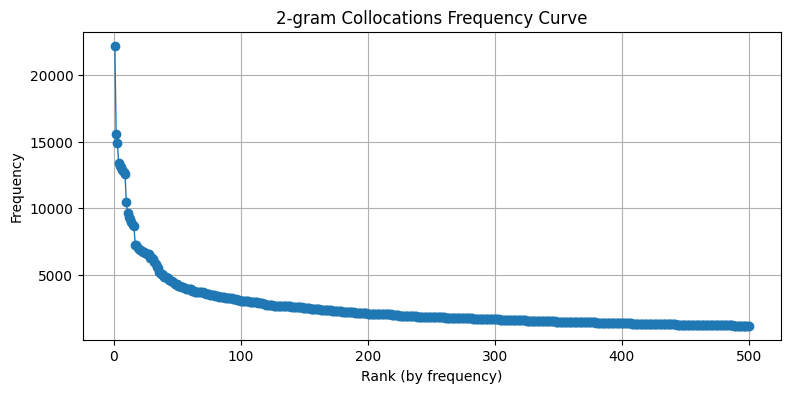


2-GRAM TOP TABLES

[TOP by FREQ]


,ngram,freq,pmi
8400,federal reserve,22212,6.780526
8271,interest rate,15575,6.822670
8843,open market,14880,6.647067
8580,reserve bank,13371,6.718480
5440,fourth quarter,13171,7.881437
7837,federal fund,13078,6.958209
9536,economic activity,12837,6.448871
9521,fund rate,12757,6.453652
4931,intermeeting period,12583,8.132952
10045,monetary policy,10477,6.307168



[TOP by PMI]


,ngram,freq,pmi
0,zeynep senyuz,31,18.168718
1,schulhofer wohl,33,18.035452
2,pernod ricard,35,17.993632
3,emergencies appropriateness,33,17.913461
4,société générale,37,17.913461
5,larsen toubro,37,17.913461
6,rebecca zarutskie,32,17.913461
7,raj rajaratnam,30,17.897948
8,nellie liang,40,17.729739
9,mercedes benz,35,17.724721



[TOP by FREQ then PMI]


,ngram,freq,pmi
8400,federal reserve,22212,6.780526
8271,interest rate,15575,6.822670
8843,open market,14880,6.647067
8580,reserve bank,13371,6.718480
5440,fourth quarter,13171,7.881437
7837,federal fund,13078,6.958209
9536,economic activity,12837,6.448871
9521,fund rate,12757,6.453652
4931,intermeeting period,12583,8.132952
10045,monetary policy,10477,6.307168


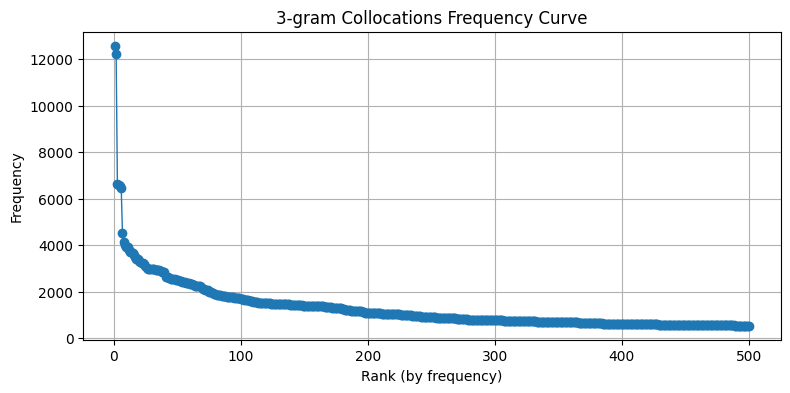


3-GRAM TOP TABLES

[TOP by FREQ]


,ngram,freq,pmi
29438,federal fund rate,12570,13.882325
28358,federal reserve bank,12230,14.039774
38238,open market committee,6632,12.646566
27032,reserve bank new,6593,14.241209
36379,federal open market,6537,12.910371
16519,bank new york,6467,16.122731
27953,system open market,4515,14.102808
8672,domestic nonfinancial debt,4148,18.309114
7671,total domestic nonfinancial,3996,18.681324
32759,sustainable economic growth,3941,13.409656



[TOP by PMI]


,ngram,freq,pmi
0,marnie gillis deboer,22,37.331198
1,kei mu yi,20,36.758208
2,burcu duygan bump,28,35.919144
3,samuel schulhofer wohl,33,35.407711
4,bristol myers squibb,22,35.355657
5,precision alterna tive,24,35.272781
6,federalreserve gov monetarypolicy,26,34.767253
7,www federalreserve gov,27,34.714786
8,monte dei paschi,59,34.294337
9,osama bin laden,33,34.194779



[TOP by FREQ then PMI]


,ngram,freq,pmi
29438,federal fund rate,12570,13.882325
28358,federal reserve bank,12230,14.039774
38238,open market committee,6632,12.646566
27032,reserve bank new,6593,14.241209
36379,federal open market,6537,12.910371
16519,bank new york,6467,16.122731
27953,system open market,4515,14.102808
8672,domestic nonfinancial debt,4148,18.309114
7671,total domestic nonfinancial,3996,18.681324
32759,sustainable economic growth,3941,13.409656


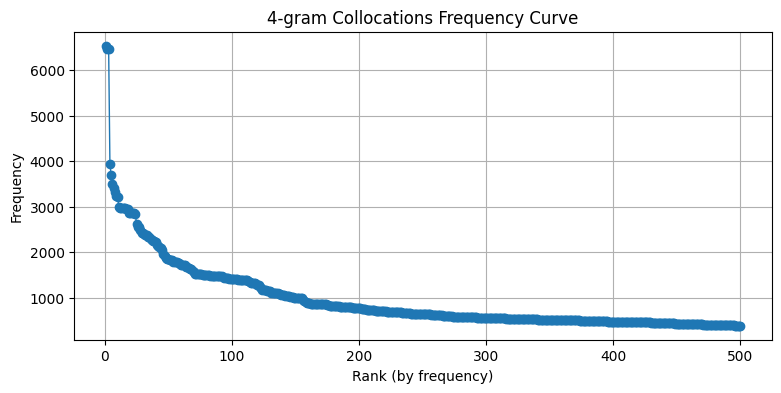


4-GRAM TOP TABLES

[TOP by FREQ]


,ngram,freq,pmi
76394,federal open market committee,6533,20.079496
39119,reserve bank new york,6463,24.149364
61361,federal reserve bank new,6459,21.666213
15151,total domestic nonfinancial debt,3927,28.325234
60500,president federal reserve bank,3690,21.750987
60910,condition reserve market consistent,3506,21.709982
50892,price stability sustainable economic,3411,22.759472
50377,stability sustainable economic growth,3315,22.813004
47933,system open market account,3242,23.097659
15276,vote action messrs greenspan,3215,28.293318



[TOP by PMI]


,ngram,freq,pmi
0,www federalreserve gov monetarypolicy,26,53.091695
1,luiz inacio lula da,10,52.166325
2,inacio lula da silva,10,51.956871
4,daw aung san suu,12,51.583468
3,aung san suu kyi,13,51.583468
5,burcu duygan bump jane,11,51.417615
6,dei paschi di siena,54,51.213950
7,sec gen kofi annan,10,51.195125
8,monte dei paschi di,54,51.069560
9,imputed owner occupy residence,11,50.701911



[TOP by FREQ then PMI]


,ngram,freq,pmi
76394,federal open market committee,6533,20.079496
39119,reserve bank new york,6463,24.149364
61361,federal reserve bank new,6459,21.666213
15151,total domestic nonfinancial debt,3927,28.325234
60500,president federal reserve bank,3690,21.750987
60910,condition reserve market consistent,3506,21.709982
50892,price stability sustainable economic,3411,22.759472
50377,stability sustainable economic growth,3315,22.813004
47933,system open market account,3242,23.097659
15276,vote action messrs greenspan,3215,28.293318


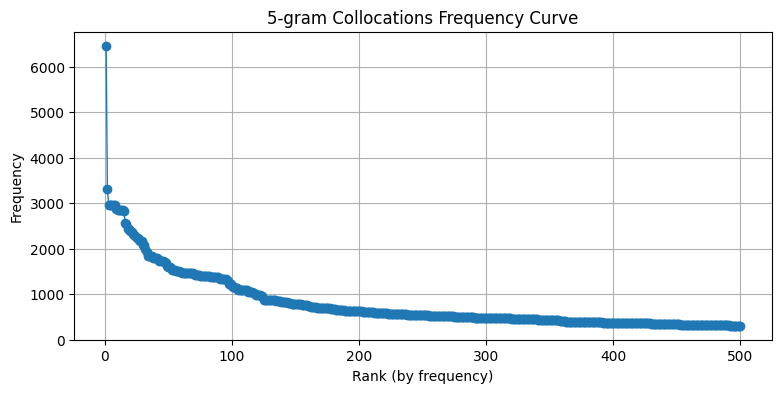


5-GRAM TOP TABLES

[TOP by FREQ]


,ngram,freq,pmi
75298,federal reserve bank new york,6459,31.607887
92709,price stability sustainable economic growth,3315,29.921273
49343,seek monetary financial condition foster,2965,34.373828
89958,open market committee seek monetary,2965,30.192224
99599,federal open market committee seek,2965,29.218580
96225,market committee seek monetary financial,2965,29.565403
80144,committee seek monetary financial condition,2965,31.134634
79478,monetary financial condition foster price,2952,31.196959
66337,vice president federal reserve bank,2868,32.508929
67614,financial condition foster price stability,2859,32.375406



[TOP by PMI]


,ngram,freq,pmi
0,http www federalreserve gov monetarypolicy,6,71.305447
1,https www federalreserve gov monetarypolicy,5,71.264805
2,daw aung san suu kyi,12,71.019613
3,luiz inacio lula da silva,10,70.093456
5,luiz incio lula da silva,5,70.093456
4,luiz inácio lula da silva,7,70.093456
6,jaguar land rover jlr volvo,6,69.740353
7,lvmh moet hennessy louis vuitton,5,69.432226
8,marnie gillis deboer min wei,5,69.397333
9,monte dei paschi di siena,54,68.373254



[TOP by FREQ then PMI]


,ngram,freq,pmi
75298,federal reserve bank new york,6459,31.607887
92709,price stability sustainable economic growth,3315,29.921273
49343,seek monetary financial condition foster,2965,34.373828
80144,committee seek monetary financial condition,2965,31.134634
89958,open market committee seek monetary,2965,30.192224
96225,market committee seek monetary financial,2965,29.565403
99599,federal open market committee seek,2965,29.218580
79478,monetary financial condition foster price,2952,31.196959
66337,vice president federal reserve bank,2868,32.508929
33452,foster price stability promote sustainable,2859,36.540534


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 너가 만든 파일명 기준
files = {
    2: 'bigram_col.csv',
    3: 'trigram_col.csv',
    4: 'fourgram_col.csv',
    5: 'fivegram_col.csv'
}

TOP_K_CURVE = 500   # 그래프에 그릴 상위 랭크 개수
TOP_N_TABLE = 20    # 표로 볼 상위 개수

def load_colloc(path):
    dfc = pd.read_csv(path)
    dfc.columns = [c.lower().strip() for c in dfc.columns]
    if 'count' in dfc.columns and 'freq' not in dfc.columns:
        dfc = dfc.rename(columns={'count': 'freq'})

    dfc = dfc[['ngram', 'freq', 'pmi']].copy()
    dfc['freq'] = pd.to_numeric(dfc['freq'], errors='coerce')
    dfc['pmi'] = pd.to_numeric(dfc['pmi'], errors='coerce')
    dfc = dfc.dropna(subset=['ngram', 'freq', 'pmi'])
    return dfc

def plot_freq_curve(dfc, n, top_k=500):
    d = dfc.sort_values('freq', ascending=False).head(top_k).reset_index(drop=True)
    x = list(range(1, len(d) + 1))

    plt.figure(figsize=(9, 4))
    plt.plot(x, d['freq'], marker='o', linewidth=1)
    plt.title(str(n) + '-gram Collocations Frequency Curve')
    plt.xlabel('Rank (by frequency)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

def show_rank_tables(dfc, n, top_n=20):
    print('\n' + '='*50)
    print(str(n) + '-GRAM TOP TABLES')
    print('='*50)

    print('\n[TOP by FREQ]')
    display(dfc.sort_values('freq', ascending=False).head(top_n))

    print('\n[TOP by PMI]')
    display(dfc.sort_values('pmi', ascending=False).head(top_n))

    print('\n[TOP by FREQ then PMI]')
    display(dfc.sort_values(['freq', 'pmi'], ascending=[False, False]).head(top_n))

# 실행
for n in [2, 3, 4, 5]:
    path = files[n]
    if not os.path.exists(path):
        print('missing :', path)
        continue

    dfc = load_colloc(path)

    # 1) 빈도 곡선 시각화
    plot_freq_curve(dfc, n, top_k=TOP_K_CURVE)

    # 2) 순위표 출력
    show_rank_tables(dfc, n, top_n=TOP_N_TABLE)

In [ ]:
import pandas as pd
import re

# 입력 파일 (너가 만든 파일명 기준)
in_files = {
    2: 'bigram_col.csv',
    3: 'trigram_col.csv',
    4: 'fourgram_col.csv',
    5: 'fivegram_col.csv'
}

# 출력 파일 (정리된 버전)
out_files = {
    2: 'bigram_col_clean.csv',
    3: 'trigram_col_clean.csv',
    4: 'fourgram_col_clean.csv',
    5: 'fivegram_col_clean.csv'
}

# n-gram별 freq 최소 기준 (너 ipynb 기준을 한 번 더 강화)
min_freq_by_n = {
    2: 50,
    3: 30,
    4: 20,
    5: 10
}

# PMI 최소 기준 (너 결과 분포 기준: 너무 낮은 결합 제거)
min_pmi_by_n = {
    2: 3.0,
    3: 10.0,
    4: 18.0,
    5: 25.0
}

# URL/도메인/잡음 토큰 제거 규칙
noise_pattern = re.compile(r'(http|https|www|\.com|\.org|\.net|\.gov|federalreserve\.gov)', re.IGNORECASE)

def clean_colloc_csv(path, n):
    dfc = pd.read_csv(path)
    dfc.columns = [c.lower().strip() for c in dfc.columns]
    if 'count' in dfc.columns and 'freq' not in dfc.columns:
        dfc = dfc.rename(columns={'count': 'freq'})

    dfc = dfc[['ngram', 'freq', 'pmi']].copy()
    dfc['freq'] = pd.to_numeric(dfc['freq'], errors='coerce')
    dfc['pmi'] = pd.to_numeric(dfc['pmi'], errors='coerce')
    dfc = dfc.dropna(subset=['ngram', 'freq', 'pmi'])

    # 1) 노이즈(사이트/URL) 제거
    dfc = dfc[~dfc['ngram'].str.contains(noise_pattern)]

    # 2) PMI + freq 동시 필터링
    dfc = dfc[(dfc['freq'] >= min_freq_by_n[n]) & (dfc['pmi'] >= min_pmi_by_n[n])]

    # 3) 정렬(실무: freq 우선 + pmi 보조)
    dfc = dfc.sort_values(['freq', 'pmi'], ascending=[False, False]).reset_index(drop=True)

    return dfc

# 실행: 2~5gram 모두 clean 파일 생성
for n in [2, 3, 4, 5]:
    df_clean = clean_colloc_csv(in_files[n], n)
    df_clean.to_csv(out_files[n], index=False, encoding='utf-8-sig')
    print('saved :', out_files[n], 'rows :', len(df_clean))

/tmp/ipython-input-3220249161.py:51: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  dfc = dfc[~dfc['ngram'].str.contains(noise_pattern)]


saved : bigram_col_clean.csv rows : 17353


/tmp/ipython-input-3220249161.py:51: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  dfc = dfc[~dfc['ngram'].str.contains(noise_pattern)]


saved : trigram_col_clean.csv rows : 32071


/tmp/ipython-input-3220249161.py:51: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  dfc = dfc[~dfc['ngram'].str.contains(noise_pattern)]


saved : fourgram_col_clean.csv rows : 62843


/tmp/ipython-input-3220249161.py:51: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  dfc = dfc[~dfc['ngram'].str.contains(noise_pattern)]


saved : fivegram_col_clean.csv rows : 98681


In [ ]:
pd.read_csv('fourgram_col_clean.csv').sort_values('pmi', ascending=False).head(20)

,ngram,freq,pmi
11667,dei paschi di siena,54,51.213950
11668,monte dei paschi di,54,51.069560
59290,annette vissing j rgensen,20,50.581919
15778,banca monte dei paschi,47,49.543491
44593,characterize precision alterna tive,24,48.744582
4346,ursula von der leyen,81,48.743596
41599,sam khater freddie mac,25,48.390654
38326,mtu aero engine ag,26,47.696065
32938,narayana kocherlakota charles plosser,28,47.497262
19880,barkin raphael w bostic,39,47.482040


In [ ]:
import pandas as pd

fourgram_clean = pd.read_csv('fourgram_col_clean.csv')

fourgram_clean.sort_values('pmi', ascending=False).head(20)

,ngram,freq,pmi
11667,dei paschi di siena,54,51.213950
11668,monte dei paschi di,54,51.069560
59290,annette vissing j rgensen,20,50.581919
15778,banca monte dei paschi,47,49.543491
44593,characterize precision alterna tive,24,48.744582
4346,ursula von der leyen,81,48.743596
41599,sam khater freddie mac,25,48.390654
38326,mtu aero engine ag,26,47.696065
32938,narayana kocherlakota charles plosser,28,47.497262
19880,barkin raphael w bostic,39,47.482040


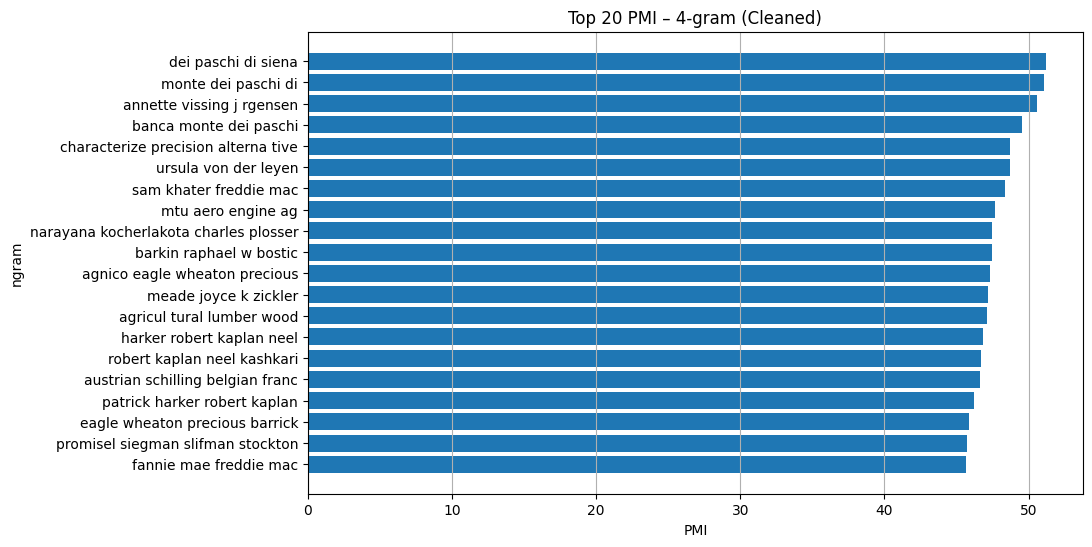

In [ ]:
import matplotlib.pyplot as plt

top20 = fourgram_clean.sort_values('pmi', ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(range(len(top20)), top20['pmi'])
plt.yticks(range(len(top20)), top20['ngram'])
plt.gca().invert_yaxis()
plt.title('Top 20 PMI – 4-gram (Cleaned)')
plt.xlabel('PMI')
plt.ylabel('ngram')
plt.grid(axis='x')
plt.show()

In [ ]:
fourgram_clean.sort_values(['freq', 'pmi'], ascending=[False, False]).head(20)

,ngram,freq,pmi
0,federal open market committee,6533,20.079496
1,reserve bank new york,6463,24.149364
2,federal reserve bank new,6459,21.666213
3,total domestic nonfinancial debt,3927,28.325234
4,president federal reserve bank,3690,21.750987
5,condition reserve market consistent,3506,21.709982
6,price stability sustainable economic,3411,22.759472
7,stability sustainable economic growth,3315,22.813004
8,system open market account,3242,23.097659
9,vote action messrs greenspan,3215,28.293318
